# Final Project Report

* Class: DS 5100
* Student Name: Austin Samhric
* Student Net ID: ars4eh
* This URL: a URL to the notebook source of this document

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL:

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

In [ ]:
'''# montecarlo.py

import numpy as np
import pandas as pd
from itertools import permutations, combinations_with_replacement


class Die:
    """
    A Die has N sides/faces and associated weights.

    Methods:
    - change_weight(face, new_weight): Change the weight of a single face.
    - roll(n=1): Roll the die n times and return results as a list.
    - show(): Return the internal dataframe of faces and weights.
    """

    def __init__(self, faces: np.ndarray):
        """
        Initialize the Die object with an array of faces.

        Parameters
        ----------
        faces : np.ndarray
            An array of distinct faces (strings or numbers).

        Raises
        ------
        TypeError
            If faces is not a NumPy array.
        ValueError
            If faces are not distinct.
        """
        if not isinstance(faces, np.ndarray):
            raise TypeError("Faces must be a NumPy array.")
        if len(set(faces)) != len(faces):
            raise ValueError("Faces must be distinct.")

        # Initialize all weights to 1.0
        self._df = pd.DataFrame({'face': faces, 'weight': np.ones(len(faces))})
        self._df.set_index('face', inplace=True)

    def change_weight(self, face, new_weight):
        """
        Change the weight of a single side of the die.

        Parameters
        ----------
        face : str or int
            The face whose weight is to be changed.
        new_weight : float or int
            The new weight.

        Raises
        ------
        IndexError
            If the face is not found in the die faces.
        TypeError
            If the new weight is not numeric.
        """
        if face not in self._df.index:
            raise IndexError("Face not found in die.")
        try:
            new_weight = float(new_weight)
        except ValueError:
            raise TypeError("Weight must be numeric.")
        self._df.at[face, 'weight'] = new_weight

    def roll(self, n=1):
        """
        Roll the die n times.

        Parameters
        ----------
        n : int, default 1
            Number of rolls.

        Returns
        -------
        list
            A list of outcomes.
        """
        faces = self._df.index.values
        weights = self._df['weight'].values
        probabilities = weights / weights.sum()
        return list(np.random.choice(faces, size=n, p=probabilities))

    def show(self):
        """
        Show the current state of the die's faces and weights.

        Returns
        -------
        pd.DataFrame
            A copy of the internal dataframe.
        """
        return self._df.copy()


class Game:
    """
    A Game consists of rolling one or more similar dice a number of times.

    Methods:
    - play(n_rolls): Roll all dice n_rolls times and store the results.
    - show(form='wide'): Show the most recent results in wide or narrow form.
    """

    def __init__(self, dice: list):
        """
        Initialize a Game with a list of Die objects.

        Parameters
        ----------
        dice : list of Die
            A list containing one or more Die objects.
        """
        self.dice = dice
        self._results = None

    def play(self, n_rolls: int):
        """
        Play the game by rolling all dice n_rolls times.

        Parameters
        ----------
        n_rolls : int
            Number of times to roll all dice.

        Stores
        ------
        self._results : pd.DataFrame
            The results of the rolls in wide format.
        """
        all_results = {}
        for i, die in enumerate(self.dice):
            all_results[i] = die.roll(n_rolls)

        self._results = pd.DataFrame(all_results)
        self._results.index.name = 'roll_number'


    def show(self, form='wide'):
        """
        Show the results of the most recent play.

        Parameters
        ----------
        form : str, default 'wide'
            'wide' or 'narrow' form of the dataframe.

        Returns
        -------
        pd.DataFrame
            The results dataframe in the specified format.

        Raises
        ------
        ValueError
            If form is not 'wide' or 'narrow'.
        """
        if self._results is None:
            return None
        if form == 'wide':
            return self._results.copy()
        else:
            # narrow form
            narrow = self._results.stack()
            narrow.index.set_names(['roll_number','die_number'], inplace=True)
            return pd.DataFrame(narrow, columns=['outcome'])


class Analyzer:
    """
    An Analyzer takes the results of a single Game and computes statistics.

    Methods:
    - jackpot(): Counts how many rolls resulted in all faces being the same.
    - face_counts_per_roll(): Computes face counts for each roll.
    - combo(): Computes combinations of faces rolled and their counts.
    - permutation(): Computes permutations of faces rolled and their counts.
    """

    def __init__(self, game: Game):
        """
        Initialize the Analyzer with a Game object.

        Parameters
        ----------
        game : Game
            The game object whose results are to be analyzed.

        Raises
        ------
        ValueError
            If the input is not a Game object.
        """
        if not isinstance(game, Game):
            raise ValueError("Analyzer requires a Game object.")
        self.game = game
        self._df_results = game.show('wide')
        self.jackpot_count = None
        self.face_counts = None
        self.combo_counts = None
        self.permutation_counts = None

    def jackpot(self):
        """
        Count how many times all dice showed the same face.

        Returns
        -------
        int
            The number of jackpots.
        """
        df = self._df_results
        self.jackpot_count = df.apply(lambda x: len(set(x)) == 1, axis=1).sum()
        return int(self.jackpot_count)

    def face_counts_per_roll(self):
        """
        Count the occurrences of each face in each roll.

        Returns
        -------
        pd.DataFrame
            Dataframe with roll_number as index, face values as columns,
            and counts as values.
        """
        df = self._df_results
        unique_faces = pd.unique(df.values.ravel())
        counts_per_roll = {}
        for idx, row in df.iterrows():
            counts = {face: (row == face).sum() for face in unique_faces}
            counts_per_roll[idx] = counts
        self.face_counts = pd.DataFrame.from_dict(counts_per_roll, orient='index', columns=unique_faces)
        return self.face_counts

    def combo(self):
        """
        Compute the distinct combinations of faces rolled, ignoring order.

        Returns
        -------
        pd.DataFrame
            MultiIndex of unique combinations and their counts.
        """
        df = self._df_results
        combo_list = df.apply(lambda x: tuple(sorted(x)), axis=1)
        combo_counts = combo_list.value_counts()
        self.combo_counts = pd.DataFrame(combo_counts, columns=['count'])
        return self.combo_counts

    def permutation(self):
        """
        Compute distinct permutations of faces rolled, order-dependent.

        Returns
        -------
        pd.DataFrame
            MultiIndex of unique permutations and their counts.
        """
        df = self._df_results
        perm_list = df.apply(lambda x: tuple(x), axis=1)
        perm_counts = perm_list.value_counts()
        self.permutation_counts = pd.DataFrame(perm_counts, columns=['count'])
        return self.permutation_counts'''

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

In [ ]:
'''# test_montecarlo.py

import unittest
import numpy as np
from montecarlo import Die, Game, Analyzer
import pandas as pd


class TestDie(unittest.TestCase):
    def setUp(self):
        self.faces = np.array([1, 2, 3])
        self.die = Die(self.faces)

    def test_init(self):
        self.assertEqual(len(self.die.show()), 3)

    def test_change_weight(self):
        self.die.change_weight(2, 2.0)
        self.assertEqual(self.die.show().loc[2, 'weight'], 2.0)

    def test_roll(self):
        result = self.die.roll(5)
        self.assertEqual(len(result), 5)

    def test_show(self):
        df = self.die.show()
        self.assertIn('weight', df.columns)


class TestGame(unittest.TestCase):
    def setUp(self):
        faces = np.array([1, 2, 3])
        d1 = Die(faces)
        d2 = Die(faces)
        self.game = Game([d1, d2])

    def test_play(self):
        self.game.play(10)
        self.assertEqual(self.game.show('wide').shape[0], 10)

    def test_show_wide(self):
        self.game.play(5)
        df_wide = self.game.show('wide')
        self.assertEqual(df_wide.shape[0], 5)

    def test_show_narrow(self):
        self.game.play(5)
        df_narrow = self.game.show('narrow')
        self.assertEqual(df_narrow.index.names, ['roll_number', 'die_number'])


class TestAnalyzer(unittest.TestCase):
    def setUp(self):
        faces = np.array([1, 2, 3])
        d1 = Die(faces)
        d2 = Die(faces)
        g = Game([d1, d2])
        g.play(10)
        self.analyzer = Analyzer(g)

    def test_init(self):
        self.assertIsInstance(self.analyzer, Analyzer)

    def test_jackpot(self):
        # Can't guarantee any jackpot with random data, but test method runs
        jp = self.analyzer.jackpot()
        self.assertIsInstance(jp, int)

    def test_face_counts_per_roll(self):
        fc = self.analyzer.face_counts_per_roll()
        self.assertIsInstance(fc, pd.DataFrame)

    def test_combo(self):
        c = self.analyzer.combo()
        self.assertIsInstance(c, pd.DataFrame)

    def test_permutation(self):
        p = self.analyzer.permutation()
        self.assertIsInstance(p, pd.DataFrame)


if __name__ == '__main__':
    unittest.main()'''

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

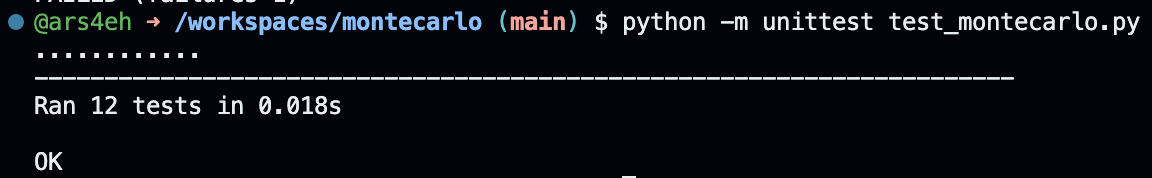

In [ ]:
'''
............
----------------------------------------------------------------------
Ran 12 tests in 0.018s

OK
'''

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [2]:
import montecarlo

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [3]:
help(montecarlo)

Help on module montecarlo:

NAME
    montecarlo - # montecarlo.py

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game: montecarlo.Game)
     |  
     |  An Analyzer takes the results of a single Game and computes statistics.
     |  
     |  Methods:
     |  - jackpot(): Counts how many rolls resulted in all faces being the same.
     |  - face_counts_per_roll(): Computes face counts for each roll.
     |  - combo(): Computes combinations of faces rolled and their counts.
     |  - permutation(): Computes permutations of faces rolled and their counts.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game: montecarlo.Game)
     |      Initialize the Analyzer with a Game object.
     |      
     |      Parameters
     |      ----------
     |      game : Game
     |          The game object whose results are to be analyzed.
     |      
     |      Raises
     |      ------
     |    

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/ars4eh/montecarlo/blob/7bf92605160838d830b245717311e06cc8545a8d/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [4]:
import numpy as np
from montecarlo import Die, Game, Analyzer

# Fair coin
faces_coin = np.array(['H','T'])
fair_coin = Die(faces_coin)

# Unfair coin (let's say 'H' has weight 5)
unfair_coin = Die(faces_coin)
unfair_coin.change_weight('H',5)

Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [5]:
game_fair = Game([fair_coin, fair_coin])
game_fair.play(1000)
results_fair = game_fair.show('wide')
results_fair.head()

,0,1
roll_number,,
0,T,T
1,T,H
2,H,H
3,H,T
4,T,H


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [6]:
game_unfair = Game([unfair_coin, unfair_coin, fair_coin])
game_unfair.play(1000)
results_unfair = game_unfair.show('wide')
results_unfair.head()

,0,1,2
roll_number,,,
0,T,H,H
1,T,H,T
2,T,T,T
3,H,H,T
4,T,H,T


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [7]:
analyzer_fair = Analyzer(game_fair)
analyzer_unfair = Analyzer(game_unfair)

fair_jackpots = analyzer_fair.jackpot()
unfair_jackpots = analyzer_unfair.jackpot()
fair_jackpots, unfair_jackpots

(505, 357)

Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [8]:
rel_fair = fair_jackpots / 1000
rel_unfair = unfair_jackpots / 1000
rel_fair, rel_unfair

(0.505, 0.357)

Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

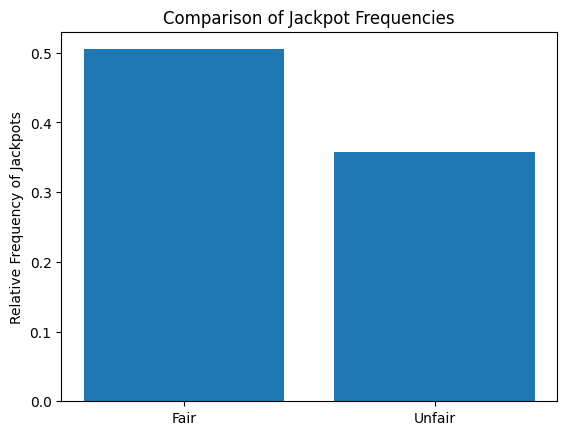

In [9]:
import matplotlib.pyplot as plt

plt.bar(['Fair','Unfair'], [rel_fair, rel_unfair])
plt.ylabel('Relative Frequency of Jackpots')
plt.title('Comparison of Jackpot Frequencies')
plt.show()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [10]:
faces_six = np.array([1,2,3,4,5,6])
d1 = Die(faces_six)
d2 = Die(faces_six)
d3 = Die(faces_six)

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [11]:
d2.change_weight(6, 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [12]:
d3.change_weight(1, 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1).
- Play method called properly (1).

In [13]:
d_fair_list = [Die(faces_six) for _ in range(5)]
game_five_fair = Game(d_fair_list)
game_five_fair.play(10000)

Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1).
- Play method called properly (1).

In [14]:
game_mixed = Game([d2, d3, Die(faces_six), Die(faces_six), Die(faces_six)])
game_mixed.play(10000)

Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

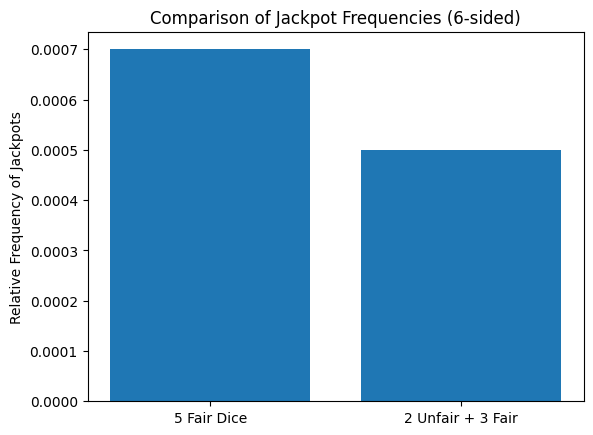

In [15]:
analyzer_five_fair = Analyzer(game_five_fair)
analyzer_mixed = Analyzer(game_mixed)

jf_five_fair = analyzer_five_fair.jackpot()
jf_mixed = analyzer_mixed.jackpot()

rel_five_fair = jf_five_fair / 10000
rel_mixed = jf_mixed / 10000

plt.bar(['5 Fair Dice','2 Unfair + 3 Fair'], [rel_five_fair, rel_mixed])
plt.ylabel('Relative Frequency of Jackpots')
plt.title('Comparison of Jackpot Frequencies (6-sided)')
plt.show()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [17]:
import string

weights_data = {}
with open('english_letters.txt','r') as f:
    for line in f:
        letter, count = line.strip().split()
        weights_data[letter] = float(count)

letters = np.array(list(string.ascii_uppercase))
letter_die = Die(letters)
for l in letters:
    letter_die.change_weight(l, weights_data[l])

Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [18]:
game_letters_4 = Game([letter_die, letter_die, letter_die, letter_die])
game_letters_4.play(1000)

Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [21]:
print(perm_df_4.head())
print(perm_df_4.index)
print(perm_df_4.columns)

              count
(T, E, E, D)      2
(T, N, S, S)      2
(E, K, E, E)      2
(A, S, N, E)      2
(N, E, E, D)      2
Index([('T', 'E', 'E', 'D'), ('T', 'N', 'S', 'S'), ('E', 'K', 'E', 'E'),
       ('A', 'S', 'N', 'E'), ('N', 'E', 'E', 'D'), ('I', 'N', 'E', 'S'),
       ('R', 'O', 'A', 'N'), ('R', 'O', 'I', 'R'), ('L', 'R', 'Y', 'E'),
       ('F', 'A', 'L', 'S'),
       ...
       ('A', 'E', 'E', 'T'), ('N', 'N', 'R', 'I'), ('N', 'R', 'E', 'R'),
       ('T', 'I', 'I', 'D'), ('I', 'A', 'A', 'S'), ('R', 'A', 'A', 'D'),
       ('Y', 'S', 'O', 'T'), ('S', 'A', 'E', 'T'), ('R', 'T', 'R', 'V'),
       ('Y', 'P', 'L', 'P')],
      dtype='object', length=991)
Index(['count'], dtype='object')


In [30]:
analyzer_letters_4 = Analyzer(game_letters_4)
perm_df_4 = analyzer_letters_4.permutation()
words_set = set()
with open('scrabble_words.txt','r') as f:
    for w in f:
        words_set.add(w.strip().upper())

# Flatten the index to simplify access
perm_df_4_reset = perm_df_4.reset_index()

count_english_words_4 = 0
for p in perm_df_4.index:
    word = ''.join(p)  # Convert the tuple to a string
    if word in words_set:  # Check if the word exists in the dictionary
        try:
            # Use flattened DataFrame for safe access
            count = perm_df_4_reset.loc[perm_df_4_reset['index'] == p, 'count'].sum()
            count_english_words_4 += count
        except Exception as e:
            print(f"Error accessing count for {p}: {e}")

print("Total English Words Count:", count_english_words_4)

Total English Words Count: 51


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [32]:
# Flatten the MultiIndex DataFrame
perm_df_5_reset = perm_df_5.reset_index()

# Initialize the count of English words
count_english_words_5 = 0

# Iterate through the index and compute the counts
for p in perm_df_5.index:
    word = ''.join(p)  # Convert tuple to string
    if word in words_set:  # Check if the word exists in the dictionary
        # Access the flattened DataFrame to safely get the count
        count = perm_df_5_reset.loc[perm_df_5_reset['index'] == p, 'count'].sum()
        count_english_words_5 += count

# Compare counts
count_english_words_5, count_english_words_4

(7, 51)

In [33]:
# Display the results
print(f"Count of English words with 4 dice: {count_english_words_4}")
print(f"Count of English words with 5 dice: {count_english_words_5}")

# Determine which produced more words
if count_english_words_5 > count_english_words_4:
    print("5 dice produced more English words than 4 dice.")
elif count_english_words_5 < count_english_words_4:
    print("4 dice produced more English words than 5 dice.")
else:
    print("4 dice and 5 dice produced the same number of English words.")

Count of English words with 4 dice: 51
Count of English words with 5 dice: 7
4 dice produced more English words than 5 dice.
